# Stationarity and Ergodicity

In addition to what’s in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install quantecon

## Overview

In this lecture we discuss stability and equilibrium behavior for continuous
time Markov chains.

To give one example of why this theory matters, consider queues, which are
often modeled as continuous time Markov chains.

Queueing theory is used in applications such as 

* treatment of patients arriving at a hospital
* optimal design of manufacturing processes 
* requests to a file server 
* air traffic
* customers waiting on a helpline

A key topic in queueing theory is average behavior over the long run.

* Will the length of the queue grow without bounds?
* If not, is there some kind of long run equilibrium?
* If so, what is the average waiting time in this equilibrium?
* What is the average length of the queue over a week, or a month?



We will use the following imports

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import quantecon as qe
from numba import njit
from scipy.linalg import expm

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


## Stationary Distributions

### Definition

Let $S$ be countable.

Recall that, for a discrete time Markov chain with Markov matrix $P$ on $S$, a
distribution $\psi$ is called stationary for $P$ if $\psi P = \psi$.

This means that if $X_t$ has distribution $\psi$, then so does $X_{t+1}$.

For continuous time Markov chains, the definition is analogous.

Given a Markov semigroup $(P_t)$ on $S$, a distribution $\psi^* \in \dD$ is called
**stationary** for $(P_t)$ if

$$
    \psi^* P_t = \psi^* 
    \text{ for all } t \geq 0
$$

As one example, we look {ref}`again <solvode>` at the chain on $S = \{0, 1,
2\}$ with intensity matrix

In [3]:
Q = ((-3, 2, 1),
     (3, -5, 2),
     (4, 6, -10))

The following figure was shown before, except that now there is a black dot
that the three trajectories seem to be converging to.

(Recall that, in the color scheme, trajectories cool as time evolves.)

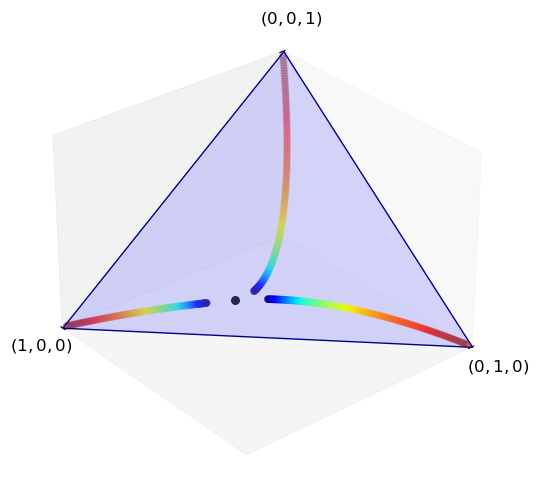

In [4]:
def unit_simplex(angle):
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    vtx = [[0, 0, 1],
           [0, 1, 0], 
           [1, 0, 0]]
    
    tri = Poly3DCollection([vtx], color='darkblue', alpha=0.3)
    tri.set_facecolor([0.5, 0.5, 1])
    ax.add_collection3d(tri)

    ax.set(xlim=(0, 1), ylim=(0, 1), zlim=(0, 1), 
           xticks=(1,), yticks=(1,), zticks=(1,))

    ax.set_xticklabels(['$(1, 0, 0)$'], fontsize=12)
    ax.set_yticklabels(['$(0, 1, 0)$'], fontsize=12)
    ax.set_zticklabels(['$(0, 0, 1)$'], fontsize=12)

    ax.xaxis.majorTicks[0].set_pad(15)
    ax.yaxis.majorTicks[0].set_pad(15)
    ax.zaxis.majorTicks[0].set_pad(35)

    ax.view_init(30, angle)

    # Move axis to origin
    ax.xaxis._axinfo['juggled'] = (0, 0, 0)
    ax.yaxis._axinfo['juggled'] = (1, 1, 1)
    ax.zaxis._axinfo['juggled'] = (2, 2, 0)
    
    ax.grid(False)
    
    return ax

Q = np.array(Q)
ψ_00 = np.array((0.01, 0.01, 0.99))
ψ_01 = np.array((0.01, 0.99, 0.01))
ψ_02 = np.array((0.99, 0.01, 0.01))

ax = unit_simplex(angle=50)    

def flow_plot(ψ, h=0.001, n=300, angle=50):
    colors = cm.jet_r(np.linspace(0.0, 1, n))

    x_vals, y_vals, z_vals = [], [], []
    for t in range(n):
        x_vals.append(ψ[0])
        y_vals.append(ψ[1])
        z_vals.append(ψ[2])
        ψ = ψ @ expm(h * Q)

    ax.scatter(x_vals, y_vals, z_vals, c=colors, s=20, alpha=0.2, depthshade=False)

flow_plot(ψ_00)
flow_plot(ψ_01)
flow_plot(ψ_02)

# Add stationary distribution
P_1 = expm(Q)
mc = qe.MarkovChain(P_1)
ψ = mc.stationary_distributions[0]
ax.scatter(ψ[0], ψ[1], ψ[2], c='k', s=30, depthshade=False)

plt.show()

This black dot is the stationary distribution $\psi^*$ of the Markov semigroup $(P_t)$ generated by $Q$.

It was calculated using the ``stationary_distributions`` attribute of QuantEcon's
[``MarkovChain`` class](https://quanteconpy.readthedocs.io/en/latest/markov.html), by arbitrarily setting $t=1$ and solving $\psi P_1 = \psi$.

Below we show that, for this choice of $Q$, the stationary distribution
$\psi^*$ is unique in $\dD$, due to irreducibility.

Moreover, $\psi P_t \to \psi^*$ as $t \to \infty$ for any $\psi \in \dD$, as
suggested by the figure.



### Stationarity via the Generator

In many cases, it is easier to use the generator of the semigroup to identify
stationary distributions rather than the semigroup itself.

This is analogous to the idea that a point $\bar x$ in $\RR^d$ is stationary for
a vector ODE $x'_t = F(x_t)$ when $F(\bar x) = 0$.

(Here $F$ is the infinitesimal description, and hence analogous to the generator.)

The next result holds true under weaker conditions but the version stated here
is easy to prove and sufficient for applications we consider.


```{prf:theorem}
:label: statfromq

Let $(P_t)$ be a UC Markov semigroup with generator $Q$.  A distribution
$\psi$ on $S$ is stationary for $(P_t)$ if and only if $\psi Q = 0$.
```

```{prf:proof}
Fix $\psi \in \dD$ and suppose first that $\psi Q = 0$.

Since $(P_t)$ is a UC Markov semigroup, we have $P_t = e^{tQ}$ for all $t$,
and hence, for any $t \geq 0$,

$$
    \psi e^{tQ} = \psi + t \psi Q + t^2 \frac{\psi Q^2}{2!} 
    + \cdots
$$

From $\psi Q = 0$ we get $\psi Q^k = 0$ for all $k \in \NN$, so the last 
display yields $\psi P_t = \psi$.

Hence $\psi$ is stationary for $(P_t)$.

Now suppose that $\psi$ is stationary for $(P_t)$ and set $D_t := (1/t) (P_t -
I)$.

From the triangle inequality and the definition of the operator norm, for any given $t$,

$$
    \| \psi Q \| 
    \leq \| \psi (Q - D_t) \| + \| \psi D_t \|
    \leq \| Q - D_t \| + \| \psi D_t \|
$$

Since $(P_t)$ is UC and $Q$ is its generator, we have $\| D_t - Q \| \to 0$ in
$\lL(\ell_1)$ as $t \to 0^+$.

Hence $\| \psi Q \| \leq \liminf_{t \downarrow 0} \| \psi D_t \|$.

As $\psi$ is stationary for $(P_t)$, we have $\psi D_t = 0$ for all $t$.

Hence $\psi Q = 0$, as was to be shown.
```



## Irreducibility and Uniqueness

Let $(P_t)$ be a Markov semigroup on $S$ and consider arbitrary states $x, y \in S$.

We say that state $y$ is **accessible** from state $x$ if
there exists a $t \geq 0$ such that $P_t(x, y) > 0$.

We say that $x$ and $y$ **communicate** if $x$ is accessible from $y$ and $y$
is accessible from $x$.

A Markov semigroup $(P_t)$ on $S$ is called **irreducible** if 
every pair $x,y$ in $S$ communicates.

We seek a characterization of irreducibility of $(P_t)$ in terms of its
generator.

As a first step, we will say there is a **$Q$-positive probability flow** from $x$
to $y$ if there exists a finite sequence $(z_i)_{i=0}^m$ in $S$ starting at
$x=z_0$ and ending at $y=z_m$ such that $Q(z_i, z_{i+1}) > 0$ for all $i$.


```{prf:theorem}
:label: equivirr

Let $(P_t)$ be a UC Markov semigroup with generator $Q$.
For distinct states $x$ and $y$, the following statements are equivalent:

1. The state $y$ is accessible from $x$ under $(P_t)$.
1. There is a $Q$-positive probability flow from $x$ to $y$.
1. $P_t(x, y) > 0$ for all $t > 0$.
```


```{prf:proof}
Pick any two distinct states $x$ and $y$.

It is obvious that statement 3 implies statement 1, so we need only prove 
(1 $\implies$ 2) and (2 $\implies$ 3).

Starting with (1 $\implies$ 2), recall that

$$
    P_t(x, y) = t Q(x,y) + \frac{t^2}{2!} Q^2(x, y) + \cdots
$$ (ptexpan)

If $x$ is accessible from $y$, then $P_t(x, y) > 0$ for some $t > 0$, so
$Q^k(x,y) > 0$ for at least one $k \in \NN$.

Writing out the matrix product as a sum, we now have

$$
    Q^k(x,y) =
    \sum_{z_1}
    \sum_{z_2}
    \cdots
    \sum_{z_{k-1}}
        Q(x, z_1) Q(z_1, z_2) \cdots Q(z_{k-1}, y) 
        > 0
$$  (qkassum)

It follows that at least one element of the sum must be strictly positive.

Therefore, a $Q$-positive probability flow from $x$ to $y$ exists.

Turning to (2 $\implies$ 3), first note that, for arbitrary states $u$ and $v$, if $Q(u, v) > 0$ then $P_t(u, v) > 0$ for all $t > 0$.

To see this, let $(\lambda, K)$ be the jump chain pair constructed from $Q$ via
{eq}`lambdafromq`, {eq}`kfromqxx` and {eq}`kfromqxy`.

Observe that, since $Q(u, v) > 0$, we must have $\lambda(u) > 0$.

As a consequence, applying {eq}`kfromqxy`, we have 

$$
    K(u, v) = \frac{Q(u, v)}{\lambda(u)} > 0
$$



Let $(Y_k)$ and $(J_k)$ be the embedded jump chain and jump sequence generated
by {prf:ref}`ejc_algo`, with $Y_0 = u$.

With $E_1 \sim \Exp(1)$ and $E_2 \sim \Exp(1)$, we have, for any $t > 0$,

$$
\begin{aligned}
    P_t(u, v) 
    & \geq \PP \{J_1 \leq t, \, Y_1 = v, \, J_2 > t \}
    \\
    & \geq \PP \{E_1 \leq t\lambda(u), \, E_2 > t\lambda(v) \} \PP\{ Y_1 = v  \}
    \\
    & = \PP \{E_1 \leq t\lambda(u)\} 
        \PP \{ E_2 > t\lambda(v) \} K(u, v) 
    \\
    & > 0
\end{aligned}
$$

Now suppose there is a $Q$-positive probability flow $(z_i)_{i=0}^m$ from $x$
to $y$.

If we fix $t > 0$ and repeatedly apply {eq}`chapkol_ct2` along with the last
result, we obtain

$$
    P_t(x, y)
    \geq
    \prod_{i=0}^{m-1} P_{t/m} (z_i, z_{i+1}) > 0
$$



```

{prf:ref}`equivirr` leads directly to the following strong result.

```{prf:corollary}
:label: perimposs
For a UC Markov semigroup $(P_t)$, the following statements are
equivalent:

1. $(P_t)$ is irreducible.
1. $P_t(x,y) > 0$ for all $t > 0$ and all $(x,y) \in S \times S$.
```


```{note}
To obtain stable long run behavior in discrete time Markov chains, it is
common to assume that the chain is aperiodic.

This needs to be assumed on top of irreducibility if one wishes to rule out
all dependence on initial conditions.

{prf:ref}`perimposs` shows that periodicity is not a concern for irreducible
continuous time Markov chains.

Positive probability flow from $x$ to $y$ at some $t > 0$ immediately implies
positive flow for all $t > 0$.

```




## Asymptotic Stabilitiy

We call Markov semigroup $(P_t)$ **asymptotically stable** if $(P_t)$ has a
unique stationary distribution $\psi^*$ in $\dD$ and

$$
    \| \psi P_t - \psi^* \| \to 0 \text{ as } t \to \infty
    \text{ for all } \psi \in \dD
$$ (asyms)

Our aim is to establish conditions for asymptotic stability of Markov
semigroups.



### Contractivity

Let's recall some useful facts about the discrete time case.

First, if $P$ is any Markov matrix, we have, in the $\ell_1$ norm,

$$
    \| \psi P \| \leq \| \psi \|
    \text{ for all } \psi \in \dD
$$ (allmocontract)

This is because, given $\psi \in \dD$, 

$$
    \| \psi P \|
    = \sum_y \left| \sum_x \psi(x) P(x, y) \right|
    \leq \sum_y \sum_x | \psi(x) | P(x, y)
    = \| \psi \|
$$

By linearity, for $\psi, \phi \in \dD$, we then have

$$
    \| \psi P - \phi P \| \leq \| \psi - \phi \|
$$ 

Hence every Markov operator is contracting on $\dD$.

Moreover, if $P$ is everywhere positive, then this inequality is strict:

```{prf:lemma} Strict Contractivity
:label: strictcontract

If $P$ is a Markov matrix and $P(x, y) > 0$ for all $x, y$, then 

$$
    \| \psi P - \phi P \| < \| \psi - \phi \|
    \text{ for all } \psi, \phi \in \dD
    \text{ with } \psi \not= \phi
$$  

```

The proof follows from the strict triangle inequality, as opposed to the weak
triangle inequality we used to obtain {eq}`allmocontract`.

See, for example, Proposition 3.1.2 of {cite}`lasota1994chaos` or Lemma 8.2.3 of {cite}`stachurski2009economic`.

### Uniqueness

Irreducibility of a given Markov chain implies that there are no disjoint
[absorbing sets](https://en.wikipedia.org/wiki/Absorbing_set).

This in turn leads to uniqueness of stationary distributions:

```{prf:theorem}
:label: uniirr

Let $(P_t)$ be a UC Markov semigroup on $S$.  If $(P_t)$ is irreducible, then
$(P_t)$ has at most one stationary distribution.
```


```{prf:proof}
Suppose to the contrary that $\psi$ and $\phi$ are both stationary for
$(P_t)$.

Since $(P_t)$ is irreducible, we know that $P_1(x,y) > 0$ for all $x,y \in S$.

If $\psi \not= \phi$, then, due to positivity of $P_1$, the strict inequality
in {prf:ref}`strictcontract` holds.

At the same time, by stationarity, $\| \psi P - \phi P \| = \| \psi - \phi
\|$.  Contradiction.
```


```{prf:example}

An M/M/1 queue with parameters $\mu, \lambda$ is a continuous time Markov chain $(X_t)$ on $S = \ZZ_+$ with with intensity matrix

$$
Q=\begin{pmatrix}
    -\lambda & \lambda & 0 & 0 & \cdots \\
    \mu & -(\mu + \lambda) & \lambda & 0 & \cdots \\
    0 & \mu & -(\mu + \lambda) & \lambda & \cdots\\
    \vdots & \vdots & \vdots & \vdots & \ddots
\end{pmatrix}
$$ (mm1q)

The chain $(X_t)$ records the length of the queue at each moment in time.

The intensity matrix captures the idea that customers flow into the queue at
rate $\lambda$ and are served (and hence leave the queue) at rate $\mu$. 

If $\lambda$ and $\mu$ are both positive, then there is a $Q$-positive
probability flow between any two states, in both directions, so the
corresponding semigroup $(P_t)$ is irreducible.

{prf:ref}`uniirr` now tells us that $(P_t)$ has at most one stationary
distribution.

```


### Stability from the Skeleton

Recall the definition of asymptotic stability given in {eq}`asyms`.

Analogously, we call an individual Markov operator $P$ asymptotically stable if 
$P$ has a unique stationary distribution $\psi^*$ in $\dD$ and
$\psi P^n \to \psi^*$ as $n \to \infty$ for all $\psi \in \dD$.

The next result gives a connection between discrete and continuous stability.

The critical ingredient linking these two concepts is the contractivity in
{eq}`allmocontract`.

```{prf:lemma}
:label: stabskel

Let $(P_t)$ be a Markov semigroup. If there exists an $s > 0$ such that the
Markov matrix $P_s$ is asymptotically stable, then $(P_t)$ is asymptotically
stable with the same stationary distribution.

```

```{prf:proof}

Let $(P_t)$ and $s$ be as in the statement of {prf:ref}`stabskel`.


Let $\psi^*$ be the stationary distribution of $P_s$.  Fix $\psi \in \dD$ and 
$\epsilon > 0$.

By stability of $P_s$, we can take an $n \in \NN$ such that
$\| \psi P_s^n - \psi^* \| < \epsilon$.

Pick any $t > sn$.  Set $h := t - sn$.  

By the contractivity in {eq}`allmocontract` and $P_{sn} = P_s^n$, we have


$$
    \| \psi P_t - \psi^* \|
    = \| \psi P_{sn} P_h - \psi^* P_h \|
    \leq \| \psi P_{sn} - \psi^* \|
    < \epsilon
$$

Hence asymptotic stability holds for $(P_t)$.

```


### Stability via Drift

In this section we address drift conditions, which are a powerful method for
obtaining asymptotic stability when the state space can be infinite. 

The idea is to show that the state tends to drift back to a finite set over
time.

Such drift, when combined with the contractivity in
{prf:ref}`strictcontract`, is enough to give global stability.

The next theorem gives a useful version of this class of results.

```{prf:theorem}
:label: sdrift

Let $(P_t)$ be a UC Markov semigroup with intensity matrix $Q$.  If $(P_t)$ is
irreducible and there exists a function $v \colon S \to \RR_+$, a finite set
$F \subset S$ and positive constants $\epsilon$ and $M$ such that

$$
    \sum_y Q(x, y) v(y) 
    \leq 
    \begin{cases}
    M & \text{ if } x \in F \text{ and }
    \\
    - \epsilon & \text{ otherwise } 
    \end{cases}
$$

then $(P_t)$ is asymptotically stable.
```

The proof of {prf:ref}`sdrift` can be found in {cite}`pichor2012stochastic`.

```{prf:example}

Consider again the M/M/1 queue on $\ZZ_+$ with intensity matrix {eq}`mm1q`.

Suppose that $\lambda < \mu$.  

It is intuitive that, in this case, the queue length will not 
tend to infinity (since the service rate is higher than the arrival rate).

This intuition can be confirmed via {prf:ref}`sdrift`, after setting $v(j) =
j$.

Indeed, we have, for any $i \geq 1$,

$$
    \sum_{j \geq 0} Q(i, j) v(j) 
    = (i-1) \mu - i (\mu + \lambda) + (i+1) \lambda
    = \lambda - \mu
$$

Setting $F=\{0\}$ and $M = \lambda - \mu = - \epsilon$, we see that the conditions
of {prf:ref}`sdrift` hold.

Hence the associated semigroup $(P_t)$ is asymptotically stable.

```


```{prf:corollary}
:label: sfinite

If $(P_t)$ is an irreducible UC Markov semigroup and $S$ is finite, then
$(P_t)$ is asymptotically stable.
```

A solved exercise below asks you to confirm this.

## Exercises

```{exercise}
:label: ergodicity-ex-1
Let $(P_t)$ be a Markov semigroup.  True or false:
for this semigroup, every state $x$ is accessible from itself.
```

```{solution} ergodicity-ex-1
:class: dropdown

The statement is true.  With $t=0$ we have $P_t(x,x) = I(x,x) = 1 > 0$.
```

```{exercise}
:label: ergodicity-ex-2
Let $(\lambda_k)$ be a bounded non-increasing sequence in $(0, \infty)$.

A **pure birth process** starting at zero is a continuous time Markov process
$(X_t)$ on state space $\ZZ_+$ with intensity matrix

$$
Q=\begin{pmatrix}
    -\lambda_0 & \lambda_0 & 0 & 0 & \cdots \\
    0 & -\lambda_1 & \lambda_1 & 0 & \cdots \\
    0 & 0 & -\lambda_2 & \lambda_2 & \cdots\\
    \vdots & \vdots & \vdots & \vdots & \ddots
\end{pmatrix}
$$

Show that $(P_t)$, the corresponding Markov semigroup, has no stationary
distribution.
```

```{solution} ergodicity-ex-2
:class: dropdown

Suppose to the contrary that $\phi \in \dD$ and $\phi Q = 0$.

Then, for any $j \geq 1$,

$$
(\phi Q)(j) 
= \sum_{i \geq 0} \phi(i) Q(i, j)
= - \lambda_j \phi(j) + \lambda_{j-1} \phi(j-1) 
= 0
$$

Since $(\lambda_k)$ is non-increasing, it follows that

$$
\frac{\phi(j)}{\phi(j-1)} = \frac{\lambda_{j-1}}{\lambda_j} \geq 1
$$

Therefore, for any $j\geq 1$, it must be:

$$
\phi(j) \geq \phi(j-1)
$$

It follows that $\phi$ is non-decreasing on $\ZZ_+$.

But $\dD$ contains no non-decreasing functions when the state space is infinite.
(Why?)

Contradiction.
```


```{exercise}
:label: ergodicity-ex-3
Confirm that {prf:ref}`sdrift` implies {prf:ref}`sfinite`.
```

```{solution} ergodicity-ex-3
:class: dropdown

Let $(P_t)$ be an irreducible UC Markov semigroup and let $S$ be finite.

Pick any positive constants $M, \epsilon$ and set $v = M$ and $F = S$.

We then have

$$
\sum_y Q(x, y) v(y)
= M \sum_y Q(x, y)
= 0
$$

Hence the drift condition in {prf:ref}`sdrift` holds and $(P_t)$ is
asymptotically stable.
```